# Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Funciones auxiliares

In [2]:
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    #from matplotlib.colors import ListedColormap
    #cm_blue_orange = ListedColormap(['tab:blue', 'orange'])
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap con Valores Numéricos y Colores')
    # Mostrar el gráfico
    plt.show()

In [30]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [31]:
# Función para entrenar y evaluar un modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [4]:
'''eliminación_hacia_atras https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.html

dataset: datos a entrenar (dataframe)
level_significance: nivel de significancia, por default 0.05

Este método hace la eliminación hacia atrás de la regresión lineal múltiple de acuerdo a un nivel de significancia (p valor)
utilizando como métrica al valor r cuadrado ajustado.
Return: Arroja una lista de los nombres de las variables más significativas para el modelo'''
def eliminacion_hacia_atras(dataset:pd.DataFrame, target:str, level_significance = 0.05):
    X = dataset.loc[:, (dataset.columns != target)]
    y = dataset.loc[:, target]
    columnas_X = X.columns.tolist()
    
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=123)
    X_train = pd.DataFrame(X_train, columns=X.columns)  # Reconstruir DataFrame para entrenamiento
    y_train = pd.Series(y_train)
    y_train.name = target

    #preparar los predictores para función OLS
    #Se agrega una columna de '1' (constante) al inicio a los predictores para el método OLS (obligatorio)
    X_OLS = sm.add_constant(X_train)
    y_OLS = y_train
    
    rsquared_adj_dictionary = {} #clave: r cuadrado ajustado, valor: nombre de las variable independiente

    while len(columnas_X) > 0:
        regression_OLS = sm.OLS(endog = y_OLS, exog = X_OLS).fit()
        
        pvalues = regression_OLS.pvalues.iloc[1:] #Se tiene los p valores del modelo // No se escoge la columna llena de 1 (constante)
        max_p_value = max(pvalues) #el mayor p valor
        model_rsquared_adj = regression_OLS.rsquared_adj # r2 ajustado del modelo

        feature_to_remove = pvalues.idxmax() #nombre de la variable a eliminar (p valor max)
        rsquared_adj_dictionary[model_rsquared_adj] = columnas_X.copy()

        #Print de los resultados estadísticos (opcional - se puede comentar)
        print('*'*80)
        print(regression_OLS.summary(), end= '\n'*2)
        print('Criterio de Información de Akaike (AIC), debe ser preferiblemente el menor entre todos los modelos:', regression_OLS.aic)
        print(rsquared_adj_dictionary[model_rsquared_adj])
        print('*'*80, end= '\n'*4)
        #Print de los resultados estadísticos (opcional - se puede comentar)

        if max_p_value > level_significance:

            X_OLS = X_OLS.drop(columns=[feature_to_remove])
            columnas_X.remove(feature_to_remove)
        else: #si ya se superó el umbral de significancia se para el ciclo while
            break

    maximo_r2_adj = max(rsquared_adj_dictionary)

    #Print de los resultados (opcional - se puede comentar)
    print('//ESTE ES EL MEJOR MODELO')
    print(f"R^2: {maximo_r2_adj}, variables de este modelo: {rsquared_adj_dictionary[maximo_r2_adj]}")
    #Print de los resultados (opcional - se puede comentar)

    return rsquared_adj_dictionary[maximo_r2_adj] + [target]

# Preprocesamiento

In [5]:
average_cluster_0=pd.read_csv("../data/interim/average_series_cluster_0.csv",parse_dates=["Date/Time"])



In [6]:
average_cluster_0.shape

(8783, 7)

In [7]:
average_cluster_0.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,47.210969,5.789775,3.010854,4.637630,6.918895,10.669373
1,2004-01-01 02:00:00,47.047291,5.946731,3.048947,4.450657,6.588343,10.525933
2,2004-01-01 03:00:00,45.619393,5.862989,2.883068,5.406697,5.084587,10.308935
3,2004-01-01 04:00:00,45.697195,6.186896,2.968095,4.801340,5.084587,10.297614
4,2004-01-01 05:00:00,47.030928,5.832209,2.942949,5.603789,5.182567,10.482863


In [8]:
average_cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8783 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8395 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8395 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8395 non-null   float64       
 4   Heating:Electricity [kW](Hourly)            8395 non-null   float64       
 5   InteriorLights:Electricity [kW](Hourly)     8395 non-null   float64       
 6   InteriorEquipment:Electricity [kW](Hourly)  8395 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 480.4 KB


In [9]:
average_cluster_0.isna().sum()

Date/Time                                       0
Electricity:Facility [kW](Hourly)             388
Fans:Electricity [kW](Hourly)                 388
Cooling:Electricity [kW](Hourly)              388
Heating:Electricity [kW](Hourly)              388
InteriorLights:Electricity [kW](Hourly)       388
InteriorEquipment:Electricity [kW](Hourly)    388
dtype: int64

In [10]:
# Imputar o eliminar valores faltantes si existen
average_cluster_0.fillna(method='ffill', inplace=True)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_14196\1271873523.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  average_cluster_0.fillna(method='ffill', inplace=True)


In [11]:
average_cluster_0.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [12]:
# Establecer la columna de fecha como índice
average_cluster_0.set_index('Date/Time', inplace=True)

In [13]:
# Extraer características temporales
average_cluster_0['hour'] = average_cluster_0.index.hour
average_cluster_0['day_of_week'] = average_cluster_0.index.dayofweek
average_cluster_0['month'] = average_cluster_0.index.month

In [14]:
average_cluster_0.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,,,
2004-01-01 01:00:00,47.210969,5.789775,3.010854,4.637630,6.918895,10.669373,1,3,1
2004-01-01 02:00:00,47.047291,5.946731,3.048947,4.450657,6.588343,10.525933,2,3,1
2004-01-01 03:00:00,45.619393,5.862989,2.883068,5.406697,5.084587,10.308935,3,3,1
2004-01-01 04:00:00,45.697195,6.186896,2.968095,4.801340,5.084587,10.297614,4,3,1
2004-01-01 05:00:00,47.030928,5.832209,2.942949,5.603789,5.182567,10.482863,5,3,1


In [15]:
average_cluster_0.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [16]:
target='Electricity:Facility [kW](Hourly)'

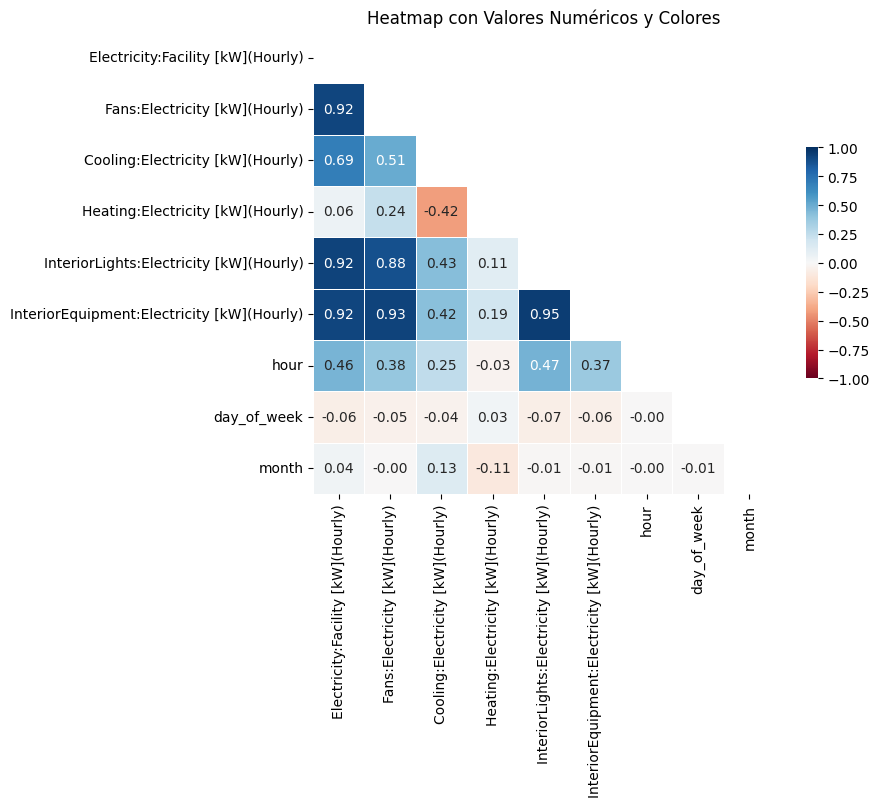

In [17]:
matriz_correlacion(average_cluster_0, target)

In [ ]:
X=average_cluster_0.drop(columns=target)
y=average_cluster_0.loc[:,target]

La correlación mide la relación entre dos variables. Puede ir de -1 a 1.

* 1 significa una relación positiva perfecta.
* -1 significa una relación negativa perfecta.
* 0 significa que no hay relación.

In [18]:
# Calcular la correlación de cada característica con la variable objetivo
correlation_matrix = average_cluster_0.corr()
target_correlation = correlation_matrix['Electricity:Facility [kW](Hourly)'].sort_values(ascending=False)

# Mostrar la correlación de cada característica con la variable objetivo
target_correlation


Electricity:Facility [kW](Hourly)             1.000000
InteriorLights:Electricity [kW](Hourly)       0.922868
Fans:Electricity [kW](Hourly)                 0.918274
InteriorEquipment:Electricity [kW](Hourly)    0.918220
Cooling:Electricity [kW](Hourly)              0.690677
hour                                          0.462181
Heating:Electricity [kW](Hourly)              0.061924
month                                         0.042512
day_of_week                                  -0.063600
Name: Electricity:Facility [kW](Hourly), dtype: float64

Queremos saber qué variables están más relacionadas con la variable que queremos predecir (Electricity:Facility [kW](Hourly)).

Las variables con alta correlación pueden ser más útiles para nuestro modelo.

**Regla utilizada:**

* Seleccionamos variables con una correlación absoluta mayor o igual a 0.3. 
* Esto significa que estas variables tienen una relación suficientemente fuerte con nuestra variable objetivo.

In [19]:
# Mantener características con correlación absoluta mayor o igual a 0.3
selected_features = target_correlation[abs(target_correlation) >= 0.3].index.drop('Electricity:Facility [kW](Hourly)')
features_corr = average_cluster_0[selected_features]

In [20]:
features_corr.columns

Index(['InteriorLights:Electricity [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'hour'],
      dtype='object')

**Evaluación de la Multicolinealidad**

* La multicolinealidad ocurre cuando dos o más variables están altamente correlacionadas entre sí.

* Esto puede causar problemas en los modelos de regresión porque dificulta determinar el efecto individual de cada variable.
  
**¿Cómo evaluamos la multicolinealidad?**

* Usamos el Factor de Inflación de la Varianza (VIF). Un VIF alto (mayor a 10) indica multicolinealidad alta.

* Eliminamos las variables con VIF mayor a 10 para reducir la multicolinealidad y simplificar nuestro modelo.

In [48]:
# Paso 3: Evaluación de la Multicolinealidad
vif_before_corr = calculate_vif(features_corr)
vif_before_corr

,feature,VIF
0,InteriorLights:Electricity [kW](Hourly),36.257326
1,Fans:Electricity [kW](Hourly),67.460746
2,InteriorEquipment:Electricity [kW](Hourly),122.403741
3,Cooling:Electricity [kW](Hourly),3.911828
4,hour,4.687435


In [49]:
# Eliminar características con VIF alto (umbral de 10)
features_selected_corr = features_corr.drop(['Fans:Electricity [kW](Hourly)','InteriorLights:Electricity [kW](Hourly)'], axis=1)
vif_after_corr = calculate_vif(features_selected_corr)

In [50]:
vif_after_corr

,feature,VIF
0,InteriorEquipment:Electricity [kW](Hourly),5.731795
1,Cooling:Electricity [kW](Hourly),3.444545
2,hour,4.103455


In [51]:
features_selected_corr

,InteriorEquipment:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),hour
Date/Time,,,
2004-01-01 01:00:00,10.669373,3.010854,1
2004-01-01 02:00:00,10.525933,3.048947,2
2004-01-01 03:00:00,10.308935,2.883068,3
2004-01-01 04:00:00,10.297614,2.968095,4
2004-01-01 05:00:00,10.482863,2.942949,5
...,...,...,...
2004-12-31 19:00:00,21.536755,6.007865,19
2004-12-31 20:00:00,19.579965,6.870403,20
2004-12-31 21:00:00,20.653062,7.675048,21


In [52]:
 taget_predict=average_cluster_0['Electricity:Facility [kW](Hourly)'].copy()

# Seleccion del modelo

In [53]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_selected_corr, taget_predict, test_size=0.2, random_state=42)

In [54]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [55]:
# Definir los modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados
results = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    mse, r2 = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {'MSE': mse, 'R2 Score': r2}


In [56]:
# Convertir a DataFrame
df_results = pd.DataFrame(results)
df_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
MSE,27.873128,27.875931,3.341219,10.273137,27.873128,5.057990,2.308517
R2 Score,0.965202,0.965198,0.995829,0.987175,0.965202,0.993685,0.997118


In [57]:
# Entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo de Random Forest
mse_train_rf, r2_train_rf = train_evaluate_model(rf_model, X_train_scaled_corr, X_train_scaled_corr, y_train_corr, y_train_corr)
mse_test_rf, r2_test_rf = train_evaluate_model(rf_model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)

# Resultados
rf_results = {
    "Random Forest": {
        'MSE Train': mse_train_rf, 
        'R2 Train': r2_train_rf,
        'MSE Test': mse_test_rf, 
        'R2 Test': r2_test_rf
    }
}

In [58]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(rf_results)
df_overfitting_results.head()

,Random Forest
MSE Test,2.308517
MSE Train,0.356370
R2 Test,0.997118
R2 Train,0.999550


# Mejorar hiperparametros

In [59]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_mean_squared_error',
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [60]:
best_params

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [61]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
mse_train_opt = mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

mse_test_opt = mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'MSE Train': mse_train_opt, 
        'R2 Train': r2_train_opt,
        'MSE Test': mse_test_opt, 
        'R2 Test': r2_test_opt
    }
}

In [62]:
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df

,Optimized Random Forest
MSE Test,2.278033
MSE Train,1.360460
R2 Test,0.997156
R2 Train,0.998283
